# Final Project: Santander Customer Satisfaction

## Name: Rafael Villalobos, David Truong, Martin Guadron

In [ ]:
pip install tensorflow
pip install lightgbm
pip install xgboost
pip install matplotlib==3.7.3

In [3]:
# Heatmap was broken on version 3.8.0

## Data Exploration
#### Here we examine the dataset provided. We peek at the column names and some of it's rows, we check to see the data types, and we pull up some basic statistics of each column. Lastly, we check to see the distribution of TARGET and the top 20 features correlating to it.

Training set shape: (76020, 371)
Test set shape: (75818, 370)

Data types in the training set:
ID                           int64
var3                         int64
var15                        int64
imp_ent_var16_ult1         float64
imp_op_var39_comer_ult1    float64
                            ...   
saldo_medio_var44_hace3    float64
saldo_medio_var44_ult1     float64
saldo_medio_var44_ult3     float64
var38                      float64
TARGET                       int64
Length: 371, dtype: object

Basic statistics for the training set:
                  ID           var3         var15  imp_ent_var16_ult1  \
count   76020.000000   76020.000000  76020.000000        76020.000000   
mean    75964.050723   -1523.199277     33.212865           86.208265   
std     43781.947379   39033.462364     12.956486         1614.757313   
min         1.000000 -999999.000000      5.000000            0.000000   
25%     38104.750000       2.000000     23.000000            0.000000   
50%     76043.0

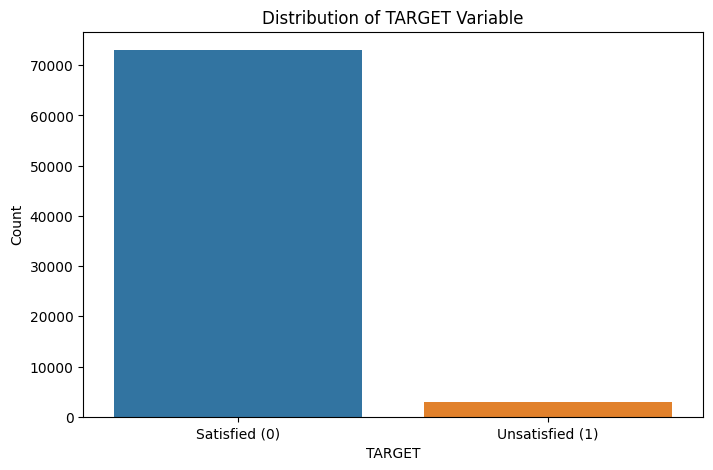

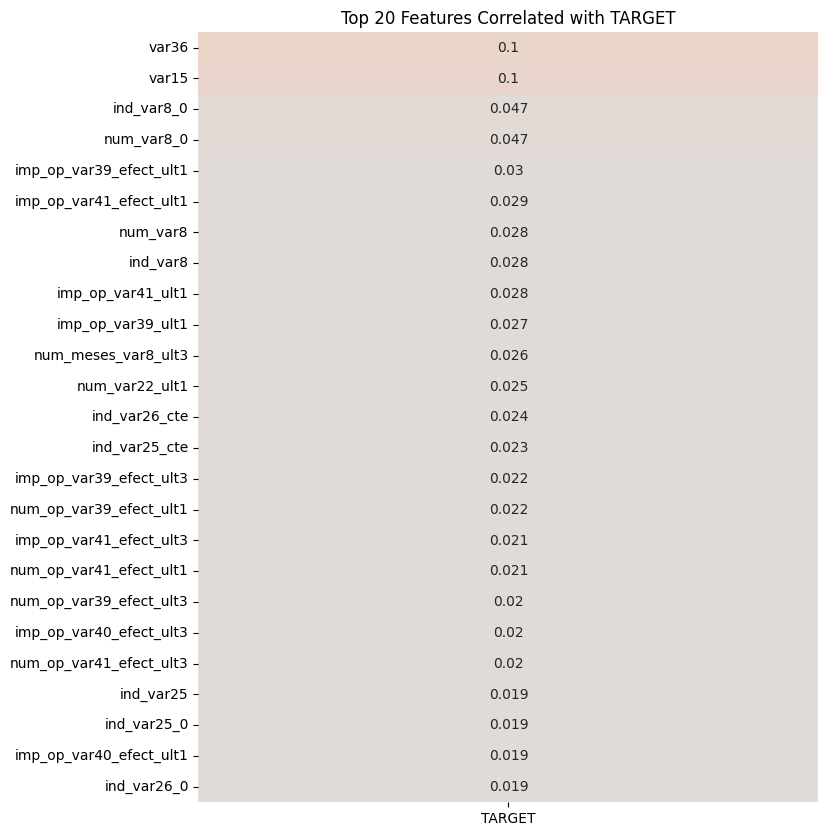

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# The 'TARGET' column is the variable to predict. It equals 1 for unsatisfied and 0 for satisfied customers

# Load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Check the size of the datasets
print(f"Training set shape: {train.shape}")
print(f"Test set shape: {test.shape}")

# Check the data types of each column
print("\nData types in the training set:")
print(train.dtypes)

# Basic statistics to understand the features
print("\nBasic statistics for the training set:")
print(train.describe())

# Check the distribution of TARGET variable
target_counts = train['TARGET'].value_counts()
print(target_counts)

# Plot the distribution
plt.figure(figsize=(8, 5))
sns.barplot(x=target_counts.index, y=target_counts.values)
plt.xlabel('TARGET')
plt.ylabel('Count')
plt.title('Distribution of TARGET Variable')
plt.xticks([0, 1], ['Satisfied (0)', 'Unsatisfied (1)'])
plt.show()

# Calculate the correlation of all features with the TARGET variable
target_corr = train.corr()['TARGET'].sort_values(ascending=False)

# Select the top 20 features with the highest absolute correlation with TARGET (excluding TARGET itself)
top_25_corr = target_corr.iloc[1:26]  # Exclude the first entry (TARGET itself) and take the next 20

# Plot the correlation of top 20 features with TARGET
plt.figure(figsize=(8, 10))
sns.heatmap(top_25_corr.to_frame(), annot=True, cmap='coolwarm', vmin=-1, vmax=1, cbar=False)
plt.title('Top 20 Features Correlated with TARGET')
plt.show()

## Random Forest, XGBoost, and LightGBM with no Data Cleaning

Random Forest Accuracy: 0.96
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21891
           1       0.19      0.02      0.04       915

    accuracy                           0.96     22806
   macro avg       0.58      0.51      0.51     22806
weighted avg       0.93      0.96      0.94     22806

XGBoost Accuracy: 0.96
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21891
           1       0.23      0.01      0.01       915

    accuracy                           0.96     22806
   macro avg       0.60      0.50      0.50     22806
weighted avg       0.93      0.96      0.94     22806

LightGBM Accuracy: 0.96
LightGBM Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     21891
           1       0.22      0.00      0.00       915

    ac

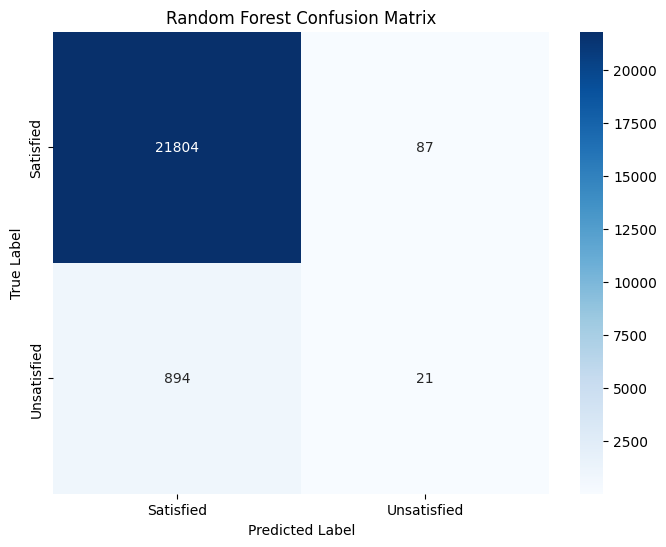

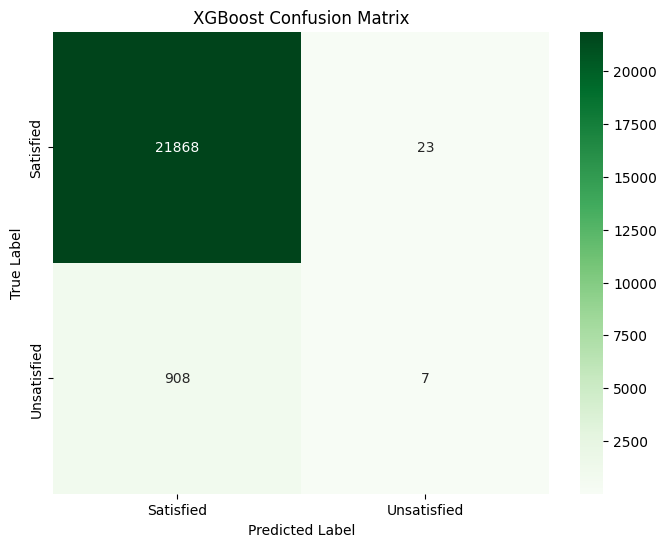

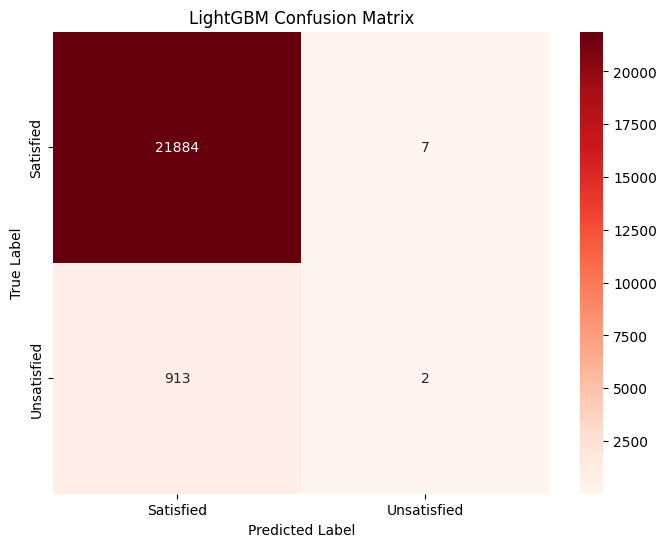

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
import lightgbm as lgb

### Step 1: Separate features (inputs) from the labels (outputs)
X = train.drop(columns=['TARGET'])
y = train['TARGET']

### Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Step 3: Train the models
# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

# LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# LightGBM model
gbm_model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

### Step 4: Make predictions
# Random Forest
rf_y_pred = rf_model.predict(X_test)
rf_y_pred_prob = rf_model.predict_proba(X_test)[:, 1]

# XGBoost
xgb_y_pred = xgb_model.predict(X_test)
xgb_y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]

# LightGBM
gbm_y_pred = gbm_model.predict(X_test)
gbm_y_pred = (gbm_y_pred > 0.5).astype(int)

### Step 5: Evaluate the models
# Random Forest Evaluation
rf_accuracy = accuracy_score(y_test, rf_y_pred)
print(f'Random Forest Accuracy: {rf_accuracy:.2f}')
print('Random Forest Classification Report:')
print(classification_report(y_test, rf_y_pred))

# XGBoost Evaluation
xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
print(f'XGBoost Accuracy: {xgb_accuracy:.2f}')
print('XGBoost Classification Report:')
print(classification_report(y_test, xgb_y_pred))

# LightGBM Evaluation
gbm_accuracy = accuracy_score(y_test, gbm_y_pred)
print(f'LightGBM Accuracy: {gbm_accuracy:.2f}')
print('LightGBM Classification Report:')
print(classification_report(y_test, gbm_y_pred))

# Random Forest Confusion Matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# XGBoost Confusion Matrix
xgb_conf_matrix = confusion_matrix(y_test, xgb_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('XGBoost Confusion Matrix')
plt.show()

# LightGBM Confusion Matrix
gbm_conf_matrix = confusion_matrix(y_test, gbm_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(gbm_conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix')
plt.show()

### Feature Importance

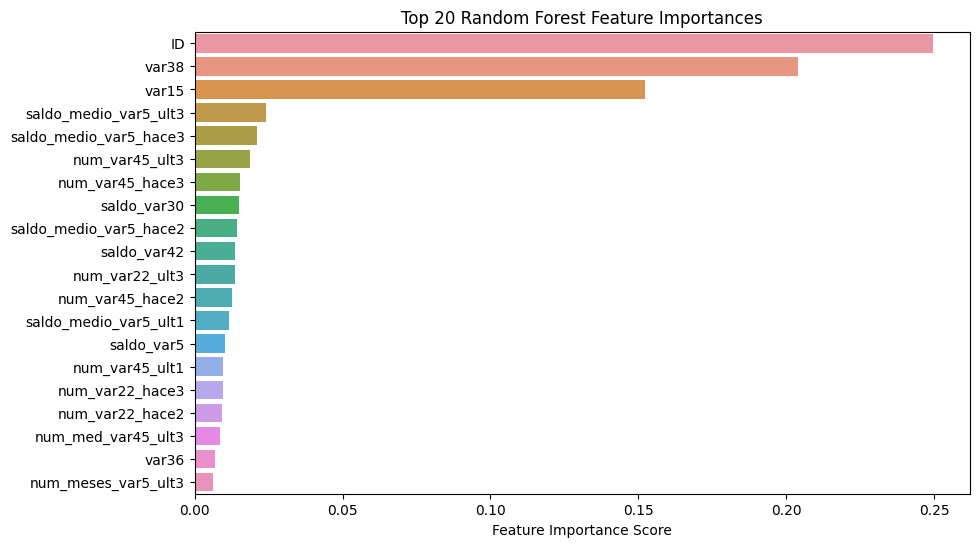

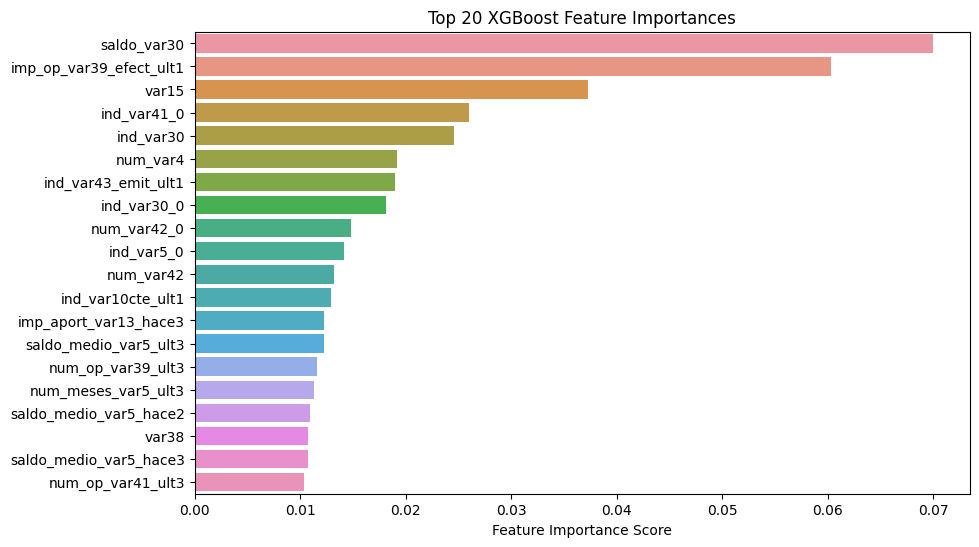

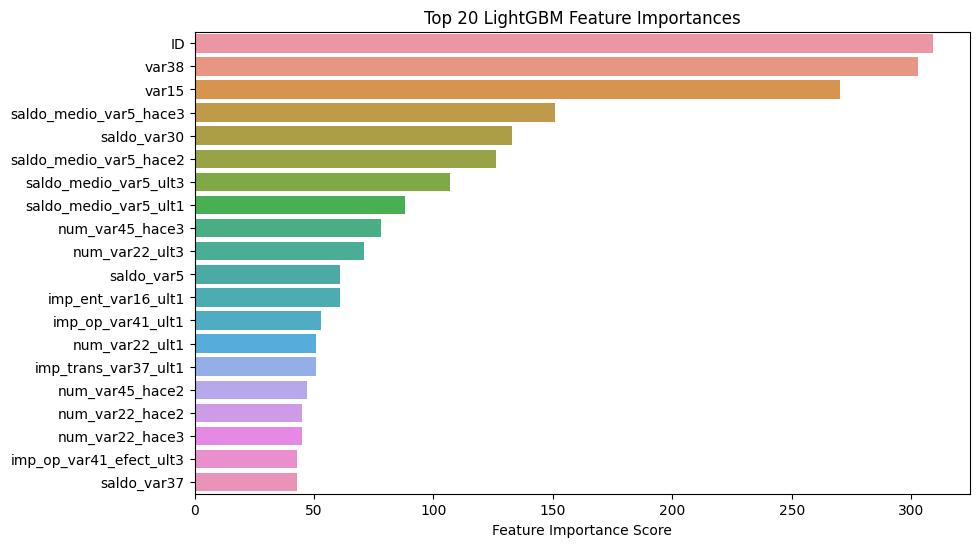

In [10]:
# Feature Importance Comparison
# Random Forest Feature Importance
rf_feature_importances = rf_model.feature_importances_
features = X.columns

# Sort features by importance
rf_sorted_indices = rf_feature_importances.argsort()[::-1]

# Plot the top 20 most important features for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importances[rf_sorted_indices][:20], y=features[rf_sorted_indices][:20])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Random Forest Feature Importances')
plt.show()

# XGBoost Feature Importance
xgb_feature_importances = xgb_model.feature_importances_

# Sort features by importance
xgb_sorted_indices = xgb_feature_importances.argsort()[::-1]

# Plot the top 20 most important features for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_feature_importances[xgb_sorted_indices][:20], y=features[xgb_sorted_indices][:20])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 XGBoost Feature Importances')
plt.show()

gbm_feature_importances = gbm_model.feature_importance()
gbm_sorted_indices = gbm_feature_importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=gbm_feature_importances[gbm_sorted_indices][:20], y=features[gbm_sorted_indices][:20])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 LightGBM Feature Importances')
plt.show()

## Random Forest with SMOTE

Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.97     14597
           1       0.15      0.14      0.14       607

    accuracy                           0.93     15204
   macro avg       0.56      0.55      0.56     15204
weighted avg       0.93      0.93      0.93     15204



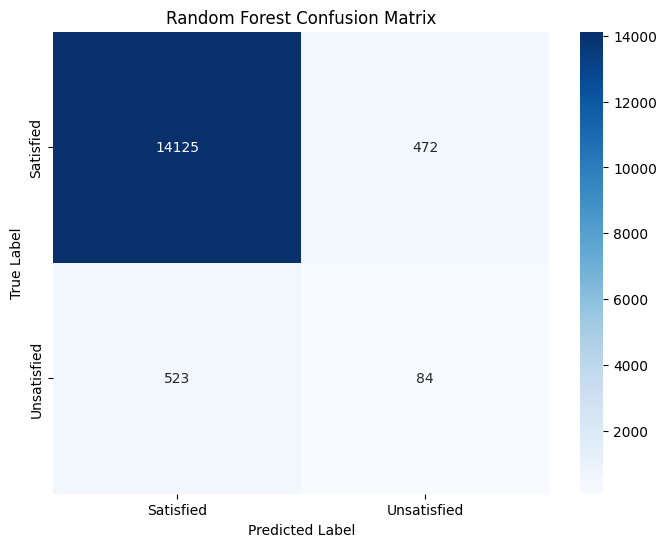

In [17]:
from imblearn.over_sampling import SMOTE

# Step 1: Separate features (inputs) from the labels (outputs)
df = pd.read_csv('train.csv')

X = df.drop(columns=['TARGET'])
y = df['TARGET']

# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Apply SMOTE to balance the dataset
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Train the model on the resampled data
rf_model.fit(X_train_resampled, y_train_resampled)

# Step 4: Make predictions
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

## Random Forest with Upsampling

Accuracy: 0.75
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       578
           1       0.76      0.76      0.76       626

    accuracy                           0.75      1204
   macro avg       0.75      0.75      0.75      1204
weighted avg       0.75      0.75      0.75      1204



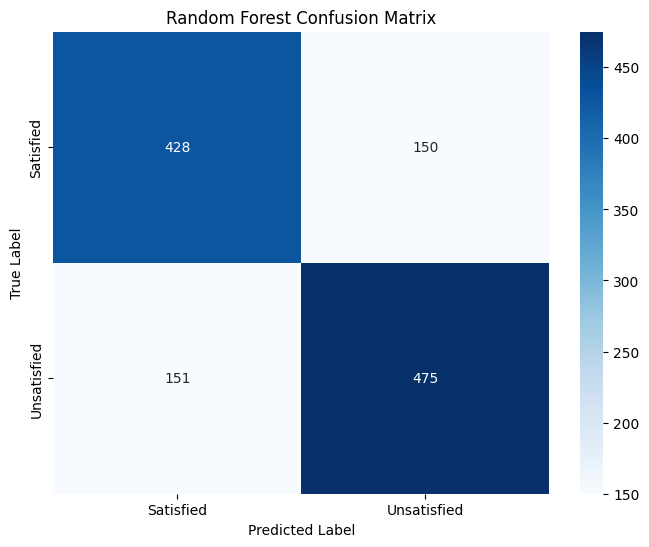

In [22]:
# Step 1: Separate features (inputs) from the labels (outputs)
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X = df_upsampled.drop(columns=['TARGET'])
y = df_upsampled['TARGET']

# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

## Random Forest with Upsampling and Important Features

Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.59      0.60       578
           1       0.63      0.65      0.64       626

    accuracy                           0.62      1204
   macro avg       0.62      0.62      0.62      1204
weighted avg       0.62      0.62      0.62      1204



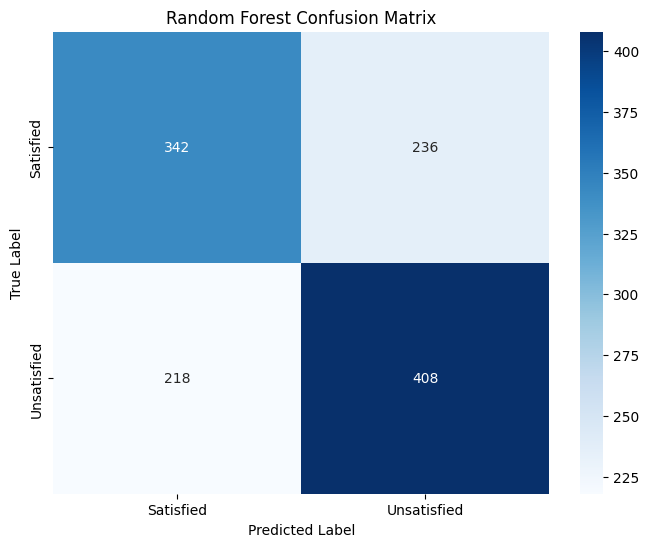

In [17]:
### Step 1: Separate features (inputs) from the labels (outputs)
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X = df_upsampled[['var38', 'var15']]
y = df_upsampled['TARGET']

# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train the model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Step 4: Make predictions
y_pred = rf_model.predict(X_test)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

## LightGBM with Upsampling

Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       578
           1       0.78      0.79      0.78       626

    accuracy                           0.77      1204
   macro avg       0.77      0.77      0.77      1204
weighted avg       0.77      0.77      0.77      1204



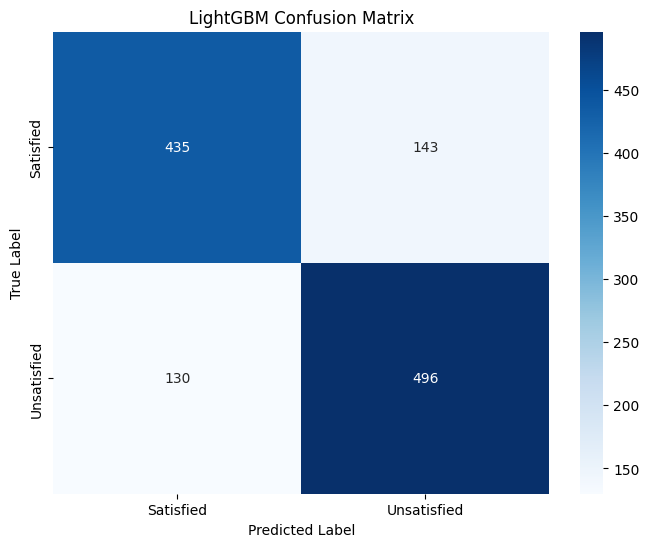

In [20]:
import lightgbm as lgb

### Step 1: Separate features (inputs) from the labels (outputs)
df = pd.read_csv('train.csv')

df_majority = df[df['TARGET'] == 1]
df_minority = df[df['TARGET'] == 0]

df_minority_upsampled = resample(df_minority, replace = True, n_samples = len(df_majority), random_state = 42)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

X = df_upsampled.drop(columns=['TARGET'])
y = df_upsampled['TARGET']

# Step 2: Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

# Set hyperparameters
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# Step 3: Train the model
model = lgb.train(params, train_data, valid_sets=[train_data, test_data])

# Step 4: Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Step 5: Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_report(y_test, y_pred))

confusion = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Satisfied', 'Unsatisfied'], yticklabels=['Satisfied', 'Unsatisfied'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('LightGBM Confusion Matrix')
plt.show()